In [1]:
import pyfits,glob,time,scipy,re,time
import scipy.interpolate
from numpy import *
import numpy
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from subprocess import call
import ipyparallel
from itertools import cycle
from scipy import misc
from scipy.ndimage import shift

matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
matplotlib.rc('font',size=30)

import pylab
pylab.rcParams['font.size']=30

segdict=dict(zip(arange(1,17),['10','11','12','13','14','15','16','17','07','06','05','04','03','02','01','00']))
%matplotlib inline

#start parallel engines
#clients=parallel.Client()
#clients.block=True
#view=clients.load_balanced_view()

In [2]:
figdir='/home/andrew/Documents/20170214 - DESC SLAC CCD OMG/'

In [3]:
thedir='/home/andrew/Work/ccd/20170901-astrometric_edge_serials/'
seriesnum,thedate='3','20170901'
catlist=sort(glob.glob(thedir+'ITL-3800C-002_spot_spot_'+seriesnum+'??_'+thedate+'??????whole.fits.cat'))
nfitsfiles=len(catlist)
print nfitsfiles," files"

100  files


In [6]:
# load in the optical encoder values from the fits headers, obtained with the command
#  gethead -h X_POS Y_POS Z_POS -x 17 ITL-3800C-033_spot_spot_9??_20170131??????.fits > 900poslist.txt
ypos,xpos,zpos=np.loadtxt(thedir+seriesnum+'00poslist.txt',skiprows=1,usecols=(1,2,3),unpack=True)

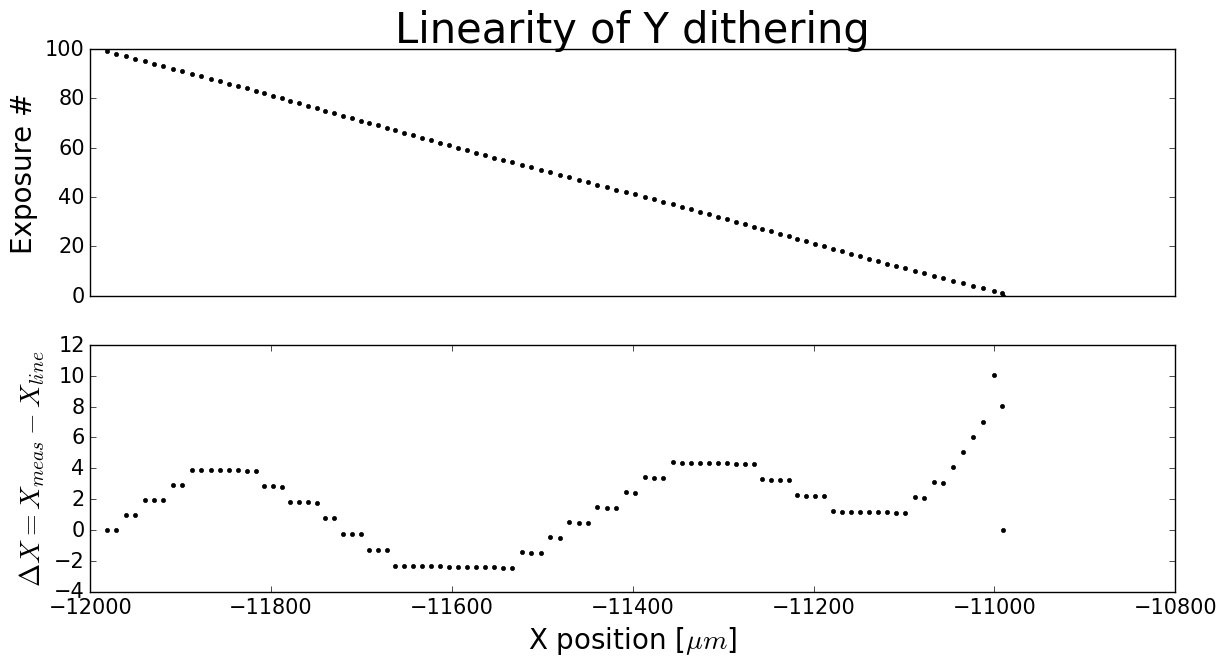

In [7]:
nc = 0 # component number 0,1,2=x,y,z
plt.figure(figsize=(14,7))
plt.subplot(211)
plt.plot(ypos,arange(100),'k.')
plt.ylabel('Exposure #',fontsize=20)
plt.xticks([])
plt.title('Linearity of Y dithering',fontsize=30)
plt.subplot(212)
plt.plot(ypos,ypos-linspace(ypos[0],ypos[-1],len(ypos)),'k.')
plt.xlabel('X position [$\\mu m$]',fontsize=20)
plt.ylabel('$\\Delta X = X_{meas} - X_{line}$',fontsize=20)
#plt.title('deviation from linear')

In [8]:
def make_reg_from_ldac(cat_ldac_file,text_tag):
    thecat=pyfits.getdata(cat_ldac_file,'LDAC_OBJECTS')
    f = open(cat_ldac_file+'.reg','w')
    for i in range(len(thecat)):
        xcoo,ycoo=thecat['XWIN_IMAGE'][i],thecat['YWIN_IMAGE'][i]
        r=thecat['A_IMAGE'][i]
        thetext=thecat[text_tag][i]
        f.write('circle '+str(xcoo)+' '+str(ycoo)+' '+str(r)+'#text="'+str(thetext)+'"\n')
    f.close()
    


def find_ave_grid_displacement(input_cat,reg_of_interest,reg_to_measurefrom,grid_spacings,tolerance):
    """Takes in an input FITS_rec/LDAC catalog and calculates the distance between all points in a region of interest
        and those in the measurement region of space. These distances are then compared to integer numbers of grid 
        spacings and the (grid prediction - actual position) is returned in the form of a list of delta_x and delta_y"""
    c=input_cat
    x0,x1,y0,y1=reg_of_interest
    u0,u1,v0,v1=reg_to_measurefrom
    #print x0,x1,y0,y1
    roi=where((c['XWIN_IMAGE']>x0) & (c['XWIN_IMAGE']<x1) & (c['YWIN_IMAGE']>y0) & (c['YWIN_IMAGE']<y1))
    roi_x,roi_y=c['XWIN_IMAGE'][roi],c['YWIN_IMAGE'][roi]
    n_roi_pts=len(roi[0])
    rom=where((c['XWIN_IMAGE']>u0) & (c['XWIN_IMAGE']<u1) & (c['YWIN_IMAGE']>v0) & (c['YWIN_IMAGE']<v1))
    rom_x,rom_y=c['XWIN_IMAGE'][rom],c['YWIN_IMAGE'][rom]
    n_rom_pts=len(rom[0])
    
    #delta_grid_x,delta_grid_y=zeros(n_roi_pts),zeros(n_roi_pts)
    delta_grid_x,delta_grid_y=[],[]
    xcoo,ycoo=[],[]
    print shape(rom_x),shape(roi_x),n_roi_pts,n_rom_pts
    for i in range(n_roi_pts):
        temp_dx,temp_dy=[],[]
        for j in range(n_rom_pts):
            xdist=roi_x[i]-rom_x[j]
            ydist=roi_y[i]-rom_y[j]
            rdist=sqrt(xdist**2+ydist**2)
            for spc in grid_spacings:
                rquot,rem=divmod(rdist,spc)
                delta_r=min(spc-rem,rem)
                if abs(delta_r)<tolerance:
                    #if the difference between grid prediction and actual position is less than the tolerance
                    # then use similar triangle rule to calculate the dx and dy from the grid position
                    rgrid=rquot*spc
                    triangle_dx=xdist*delta_r/rdist
                    triangle_dy=ydist*delta_r/rdist
                    temp_dx.append(triangle_dx)
                    temp_dy.append(triangle_dy)
        #delta_grid_x[i]=median(temp_dx)
        #delta_grid_y[i]=median(temp_dy)
        delta_grid_x.extend(np.array(temp_dx))
        delta_grid_y.extend(np.array(temp_dy))
        xcoo.extend([roi_x[i]]*len(temp_dx))
        ycoo.extend([roi_y[i]]*len(temp_dx))
    
    return xcoo,ycoo,delta_grid_x,delta_grid_y


def find_2exp_shift(cat1,cat2,tolerance,roi_ref):
    """Takes in two catalogs, assumed to be taken one after another with a small x/y dither in between
    and outputs the median x and y shift, and their errors, in pixels""" 
    xoff,yoff=[],[]
    xlo,xhi,ylo,yhi=roi_ref
    cat1=cat1[where((cat1['XWIN_IMAGE']>xlo) & (cat1['XWIN_IMAGE']<xhi) & 
                    (cat1['YWIN_IMAGE']>ylo) & (cat1['YWIN_IMAGE']<yhi))] 
    nobj1=len(cat1['XWIN_IMAGE'])
    for i in range(nobj1):
        x1,y1=cat1['XWIN_IMAGE'][i],cat1['YWIN_IMAGE'][i]
        closest=where((abs(cat2['XWIN_IMAGE']-x1)<tolerance) & (abs(cat2['YWIN_IMAGE']-y1)<tolerance))
        x2,y2=cat2['XWIN_IMAGE'][closest],cat2['YWIN_IMAGE'][closest]
        xoff.extend(x2-x1),yoff.extend(y2-y1)
    mx,my=median(xoff),median(yoff)
    sx,sy=std(xoff),std(yoff)
    return mx,my,sx,sy,xoff,yoff

def find_ave_grid_displacement_from_shift(cat1,cat2,xshift,yshift,reg_of_interest,tolerance,ddirec):
    """Takes in two input FITS_rec/LDAC catalogs and a shift (from find_2exp_shift) and calculates the difference between the predicted 
    shifted position of a pinhole and the actual position. Returns the coordinates of the shifted pinholes and the differences in X & Y"""
    if (((ddirec=='+x') & (xshift>0)) | ((ddirec=='-x') & (xshift<0))):
        c1,c2=cat1,cat2
    if (((ddirec=='+x') & (xshift<0)) | ((ddirec=='-x') & (xshift>0))):
        c1,c2=cat2,cat1
        xshift=-1*xshift
    if (((ddirec=='+y') & (yshift>0)) | ((ddirec=='-y') & (yshift<0))):
        c1,c2=cat1,cat2
    if (((ddirec=='+y') & (yshift<0)) | ((ddirec=='-y') & (yshift>0))):
        c1,c2=cat2,cat1
        yshift=-1*yshift
    xlo,xhi,ylo,yhi=reg_of_interest
    roi=where((c2['XWIN_IMAGE']>xlo) & (c2['XWIN_IMAGE']<xhi) & (c2['YWIN_IMAGE']>ylo) & (c2['YWIN_IMAGE']<yhi))[0]
    delta_grid_x,delta_grid_y=[],[]
    xcoo,ycoo=[],[]
    c1_ind,c2_ind=[],[]
    x1,y1=c1['XWIN_IMAGE'],c1['YWIN_IMAGE']
    mags=[]
    for i in roi:
        x2,y2=c2['XWIN_IMAGE'][i],c2['YWIN_IMAGE'][i]
        closest=where((abs(x2-x1+xshift)<tolerance) & (abs(y2-y1+yshift)<tolerance))[0]
        if len(closest)==1:
            x_ref,y_ref=x1[closest],y1[closest]
            x_pred,y_pred=x_ref+xshift,y_ref+yshift
            dx=(x_pred-x2)
            dy=(y_pred-y2)
            delta_grid_x.extend(dx),delta_grid_y.extend(dy)
            xcoo.extend(x_pred) #should this be x1&y1?
            ycoo.extend(y_pred)
            c1_ind.append(closest)
            c2_ind.append(i)
            mags.extend(c1['MAG_AUTO'][closest])
        
    return xcoo,ycoo,delta_grid_x,delta_grid_y,c1_ind,c2_ind,mags

def sequential_cat_calc_grid_offset(cats,roi,roi_ref,tolerance,ddirec):
    """Takes in a list of FITS LDAC catalogs, a region of interest to find offsets, and a grid finding tolerance
    and outputs a list of object coordinates with their grid offsets, as well as a running
    tally of where the grid is shifting in X and Y"""
    mxshift,myshift=[],[]
    xrun,yrun=[],[]
    xfoo,yfoo=0,0
    xcoo,ycoo=[],[]
    delta_grid_x,delta_grid_y=[],[]
    magsf=[]
    ncats=len(cats)
    for i in range(ncats-1):
        cat1=cats[i]
        cat2=cats[i+1]
        mx,my,sx,sy,xoff,yoff=find_2exp_shift(cat1,cat2,tol,roi_ref)
        if ((abs(mx)<tol) & (abs(my)<tol) & (sx<.05) & (sy<.05)):
            xfoo+=mx
            yfoo+=my
            x,y,dgx,dgy,c1_ind,c2_ind,mags=find_ave_grid_displacement_from_shift(cat1,cat2,mx,my,roi,tol,ddirec)
            xrun.append(xfoo)
            yrun.append(yfoo)
            mxshift.append(mx),myshift.append(my)
            xcoo.extend(x),ycoo.extend(y)
            delta_grid_x.extend(dgx),delta_grid_y.extend(dgy)
            magsf.extend(mags)
            #print c1_ind[0]
            #mags.append(cat1['MAG_AUTO'][c1_ind[0]])
        #print i,mx,my,sx,sy
    return np.array(xcoo),np.array(ycoo),np.array(delta_grid_x),np.array(delta_grid_y),np.array(xrun),np.array(yrun),np.array(magsf)


def median_xy(xin,yin,nxbins):
    xmin,xmax=xin.min(),xin.max()
    xbin=linspace(xmin,xmax,nxbins+1)
    ymed=zeros(nxbins)
    errbar=zeros(nxbins)
    for i in range(nxbins):
        gd=where((xin>xbin[i]) & (xin<xbin[i+1]))[0]
        ymed[i]=np.median(yin[gd])
        errbar[i]=np.std(yin[gd])/np.sqrt(len(gd))
    return np.array(xbin[:-1]),ymed,errbar

In [15]:
ncats=100
seriesnum=5
gridcatslist=sort(glob.glob(thedir+'/*_'+str(seriesnum)+'??_'+thedate+'*whole.fits.cat'))
gridcats=[pyfits.getdata(gridcatslist[i],'LDAC_OBJECTS') for i in range(ncats)]
print len(gridcats)

100


In [16]:
roi=[250,350,0,80]
roi_ref=[250,350,10,80]#roi#[50,450,50,450]
ncats=100
tol=5
ddirec='-'
xory='y'
thedate='20170901'

savename=thedir+'astroresid-'+thedate+'-edge-5series.txt'

t1=time.time()
x,y,dgx,dgy,xr,yr,mags=sequential_cat_calc_grid_offset(gridcats,roi,roi_ref,tol,ddirec+xory)
savetxt(savename,(x,y,dgx,dgy,mags))
print time.time()-t1

3.53802895546


<Container object of 3 artists>

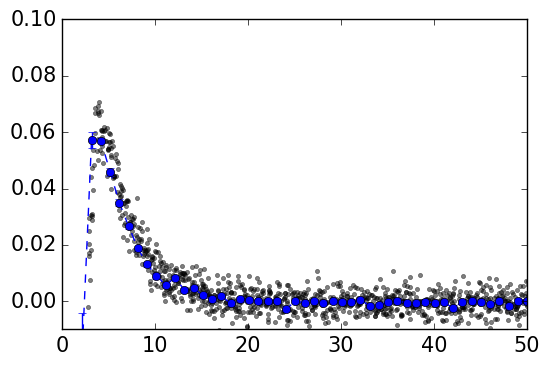

In [18]:
#ncats=100
#seriesnum=9
#gridcatslist=sort(glob.glob(thedir+'/*_'+str(seriesnum)+'??_'+thedate+'*wholeflat.fits.cat'))
#gridcats=[pyfits.getdata(gridcatslist[i],'LDAC_OBJECTS') for i in range(ncats)]

reduc_fac=1
xmedfoo,ymedfoo,yerr=median_xy(y,dgy,int((roi[3]-roi[2])/reduc_fac))

plt.plot(y,dgy,'k.',alpha=.5)
plt.axis([0,50,-.01,.1])
plt.errorbar(xmedfoo,ymedfoo,yerr=yerr,marker='o',linestyle='--')

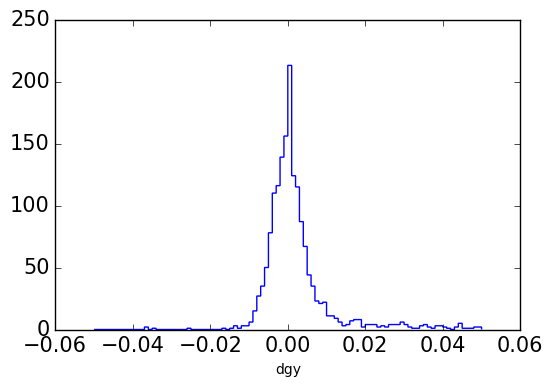

In [19]:
plt.hist(dgy,bins=100,range=[-.05,.05],histtype='step')
plt.xlabel('dgy')

In [90]:
# LIST OF COMMONLY USED AREAS
top_edge=[700,900,3200,4000]#top edge
top_edgel=[520,1500,3600,4000]
bot_edge=[520,900,0,800]#[690,900,0,800]
bot_edgel=[0,2000,0,400]

In [23]:
thedir+'/*_'+str(seriesnum)+'??_'+thedate+'*whole.fits.cat'

'/home/andrew/Work/ccd/20170901-astrometric_edge_serials//*_3??_20170131*whole.fits.cat'

In [96]:
seriesnum=5
thedate='20170901'
roi,area_name=bot_edge,'bot_edge'
savename=thedir+'astroresid-'+thedate+'-'+area_name+'-series'+str(seriesnum)

sf=.1
sx,sy=roi[1]-roi[0],roi[3]-roi[2]
roi_ref=[roi[0]+sf*sx,roi[1]+sf*sx,roi[2]+sf*sy,roi[3]-sf*sy]
ev=2
tol=5
ncats=100



ddirec,xory='-','y'
gridcatslist=sort(glob.glob(thedir+'/*_'+str(seriesnum)+'??_'+thedate+'*whole.fits.cat'))
gridcats=[pyfits.getdata(gridcatslist[i],'LDAC_OBJECTS') for i in range(ncats)][::ev]
t1=time.time()
x,y,dgx,dgy,xr,yr,mags=sequential_cat_calc_grid_offset(gridcats,roi,roi_ref,tol,ddirec+xory)
savetxt(savename+ddirec+xory+'.txt',(x,y,dgx,dgy,mags))
print time.time()-t1, savename

40.9938960075 /home/andrew/Work/ccd/20170901-astrometric_edge_serials/astroresid-20170901-bot_edge-series5


## test plotting

In [40]:
int((gary[3]-gary[2])/reduc_fac)

800

[0, 30, -0.005, 0.2]

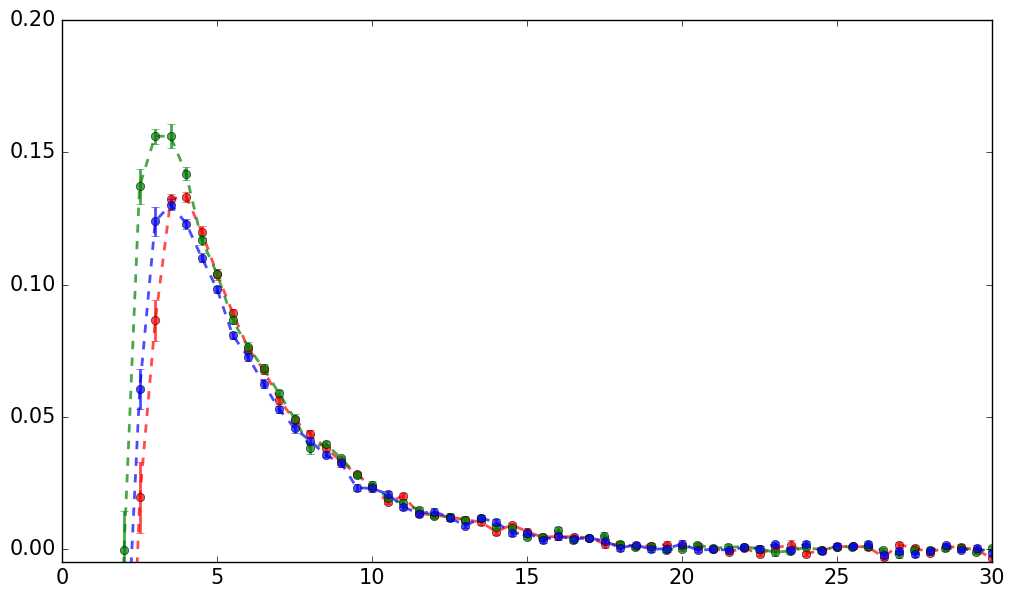

In [98]:
reduc_fac=.5
area_name='bot_edge'
xpmin,xpmax=0,30#3950,4000  #min and max x axis
yamin,yamax=-.005,.2   #min and max astrometric y axis
gary=roi#[690,700,0,100] 

plt.figure(figsize=(12,7))
seriesnum=3
savename=thedir+'astroresid-'+thedate+'-'+area_name+'-series'+str(seriesnum)+'-y.txt'
dx,dy,dgx,dgy,m=loadtxt(savename)
greg=np.where((dx>gary[0]) & (dx<gary[1]) & (dy>gary[2]) &(dy<gary[3]))
xmedfoo,ymedfoo,yerr=median_xy(dy[greg],dgy[greg],int((gary[3]-gary[2])/reduc_fac))
plt.errorbar(xmedfoo,ymedfoo,yerr=yerr,marker='o',linestyle='--',alpha=.7,lw=2,color='r')
#plt.plot(dy,dgy,'r.')

seriesnum=4
savename=thedir+'astroresid-'+thedate+'-'+area_name+'-series'+str(seriesnum)+'-y.txt'
dx,dy,dgx,dgy,m=loadtxt(savename)
greg=np.where((dx>gary[0]) & (dx<gary[1]) & (dy>gary[2]) &(dy<gary[3]))
xmedfoo,ymedfoo,yerr=median_xy(dy[greg],dgy[greg],int((gary[3]-gary[2])/reduc_fac))
plt.errorbar(xmedfoo,ymedfoo,yerr=yerr,marker='o',linestyle='--',alpha=.7,lw=2,color='g')
#plt.plot(dy,dgy,'g.')

seriesnum=5
savename_flat=savename=thedir+'astroresid-'+thedate+'-'+area_name+'-series'+str(seriesnum)+'-y.txt'
dx,dy,dgx,dgy,m=loadtxt(savename)
greg=np.where((dx>gary[0]) & (dx<gary[1]) & (dy>gary[2]) &(dy<gary[3]))
xmedfoo,ymedfoo,yerr=median_xy(dy[greg],dgy[greg],int((gary[3]-gary[2])/reduc_fac))
plt.errorbar(xmedfoo,ymedfoo,yerr=yerr,marker='o',linestyle='--',alpha=.7,lw=2,color='b')
#plt.plot(dy,dgy,'b.')


#greg=np.where((dx>gary[0]) & (dx<gary[1]) & (dy>gary[2]) &(dy<gary[3]))
#xmedfoo,ymedfoo,yerr=median_xy(dy[greg],dgy[greg],int((gary[3]-gary[2])/reduc_fac))
#plt.errorbar(xmedfoo,ymedfoo,yerr=yerr,marker='o',linestyle='--',alpha=.7,lw=2)

#plt.figure(figsize=(20,6))
#plt.errorbar(xmedfoo,ymedfoo,yerr=yerr,marker='o',linestyle='--',alpha=.7,lw=2)
#             label='astrom. error',color='g')
#plt.errorbar(xmedfoo,ymedfoo,yerr=yerr,marker='o',linestyle='-.')
#inds=np.array(dy).argsort()
#sortedy=np.array(dy)[inds]
#sorteddy=np.array(dgy)[inds]
#plt.plot(sortedy,sorteddy,'k.',alpha=.1)
#plt.plot(dy,dgy,'r.')

plt.axis([xpmin,xpmax,yamin,yamax])

In [6]:
filtflat=pyfits.getdata('/home/andrew/Work/ccd/20170130-flats/flatfilt150.fits')
filtflat*=-1  # because I did highpass= (blurred - unblurred)

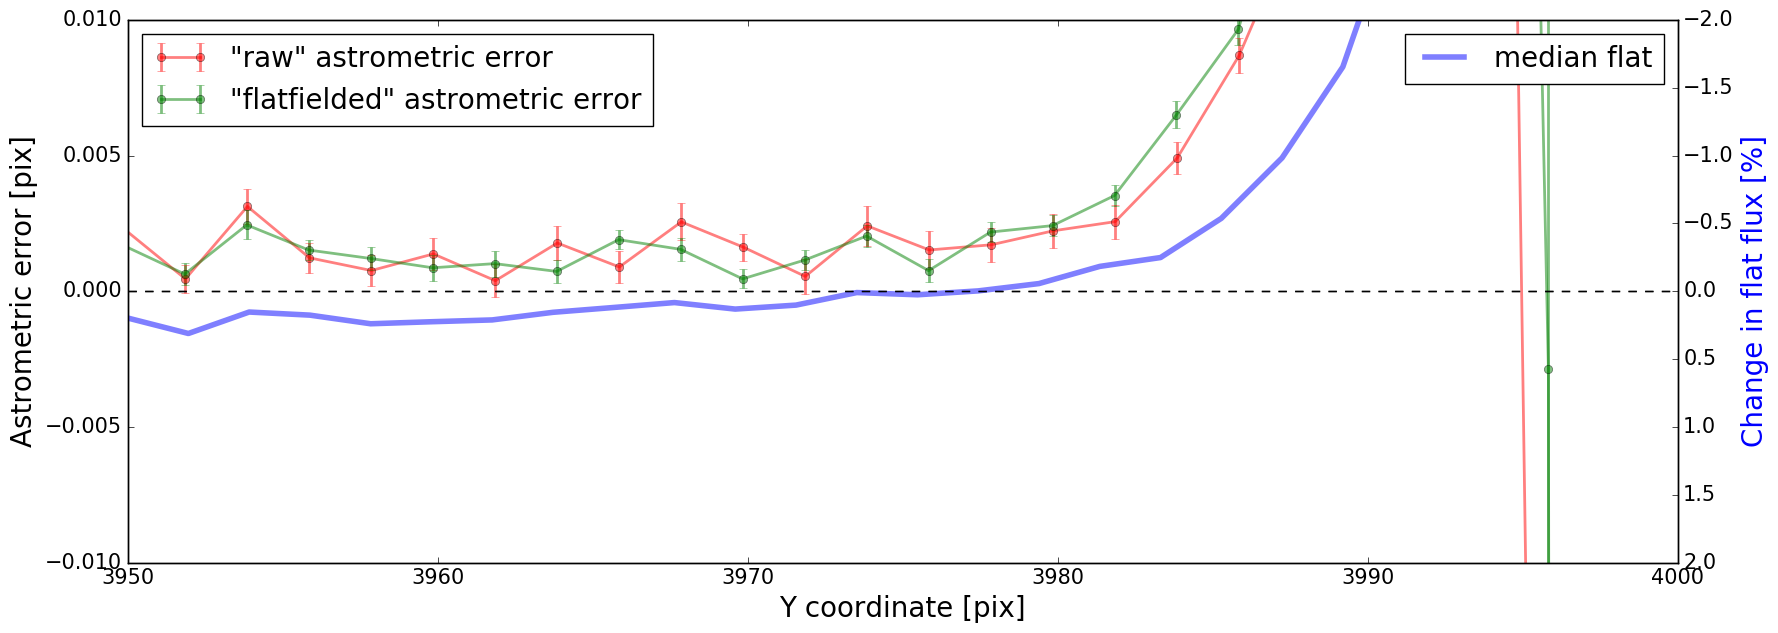

In [439]:
fig,ax1=plt.subplots(figsize=(20,7))#(figsize=(8,8))

area_name='top_edge'

savename_noflat=thedir+'astroresid-'+thedate+'-'+area_name+'-y.txt'
savename_flat=savename=thedir+'astroresid-'+thedate+'-'+area_name+'-flat-y.txt'

reduc_fac=2

xpmin,xpmax=3950,4000#3450,3540#
yamin,yamax=-.01,.01
yfmin,yfmax=2,-2


dx,dy,dgx,dgy,m=loadtxt(savename_noflat)

xmedfoo,ymedfoo,yerr=median_xy(dy,dgy,int((roi[3]-roi[2])/reduc_fac))
ax1.errorbar(xmedfoo,ymedfoo,yerr=yerr,marker='o',linestyle='-',alpha=.5,lw=2,
             label='"raw" astrometric error',color='r')

dx,dy,dgx,dgy,m=loadtxt(savename_flat)
xmedfoo,ymedfoo,yerr=median_xy(dy,dgy,int((roi[3]-roi[2])/reduc_fac))
ax1.errorbar(xmedfoo,ymedfoo,yerr=yerr,marker='o',linestyle='-',alpha=.5,lw=2,
             label='"flatfielded" astrometric error',color='g')

ax1.axhline(0,linestyle='--',color='k')
ax1.set_ylabel('Astrometric error [pix]',fontsize=20)
ax1.set_xlabel('Y coordinate [pix]',fontsize=20)
plt.axis([xpmin,xpmax,yamin,yamax])
plt.legend(fontsize=20,loc='upper left')

#make a slice through the flat by median stacking line slices
xstart,xend=int(min(dx)),int(max(dx))#xstart+0
nxpix,nypix=xend-xstart,xpmax-xpmin
flat_stripe_val=np.array([filtflat[xpmin:xpmax,xi] for xi in range(xstart,xend)]).flatten()
flat_stripe_coord=np.array([np.arange(xpmin,xpmax)]*nxpix).flatten()
med_stripe_coord,med_stripe_val,flaterr=median_xy(flat_stripe_coord,flat_stripe_val,int(nypix/reduc_fac))

ax2=ax1.twinx()
ax2.plot(med_stripe_coord,med_stripe_val,alpha=.5,lw=4,
             label='median flat',linestyle='-',color='b')
#ax2.errorbar(med_stripe_coord,med_stripe_val,yerr=flaterr,alpha=.7,lw=2,
#             label='median flat',marker='o',linestyle='--',color='b')
ax2.set_ylabel('Change in flat flux [%]',fontsize=20,color='b')
ax2.axhline(0,linestyle='--',color='k')
plt.legend(fontsize=20,loc='upper right')
plt.ylim(-1,1)#
plt.axis([xpmin,xpmax,yfmin,yfmax])

plt.savefig(figdir+'astrometric_error_'+area_name+'-zoom1.png',dpi=150)

In [142]:
roi

[750, 850, 3000, 3550]

In [ ]:
# GO BACK TO SRD FOR SHEAR MULT./ADD. BIAS NEEDS, SHEAR CORR FUNCTION 10^-7?
# from astrometric error to shear, units says it should be something like dx-dy/(dxy)?

# Add a line to the above plot: "flatfielded" astrometric error, i.e. how well does the old method work for tree rings (and edge effect). Should hopefully illustrate the important point, which is that the *pixel boundaries* are most important and need to be explored and modeled...maybe not for tree rings but definitely for the edge effect and other regions of high transverse electric fields! / BOOM

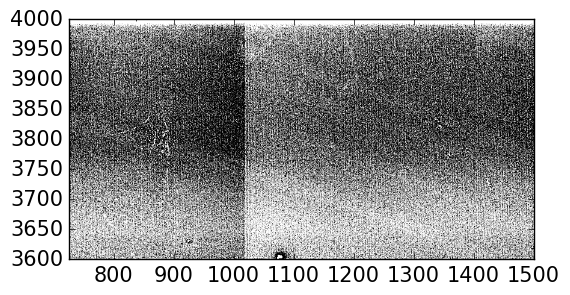

In [7]:
plt.figure(figsize=(6,6))
xpmin,xpmax=725,1500
ypmin,ypmax=3600,4000#3950,4000
plt.imshow(filtflat[ypmin:ypmax,xpmin:xpmax],vmin=-1,vmax=1,origin='lower',
           cmap=plt.cm.Greys,extent=[xpmin,xpmax,ypmin,ypmax])

In [68]:
thedir

'/home/andrew/Work/ccd/20170901-astrometric_edge_serials/'

In [73]:


roi,area_name=bot_edge,'bot_edge'

seriesnum=5
savename=thedir+'astroresid-'+thedate+'-'+area_name+'-series'+str(seriesnum)+'-y.txt'
ydx,ydy,ydgx,ydgy,m=loadtxt(savename_noflat_y)

pix_wid=1

xpmin,xpmax=roi[0],roi[1]#700,900
ypmin,ypmax=roi[2],roi[3]#3200,4000#3950,4000
dxp,dyp=(xpmax-xpmin),(ypmax-ypmin)



[690, 900, 0, 800]

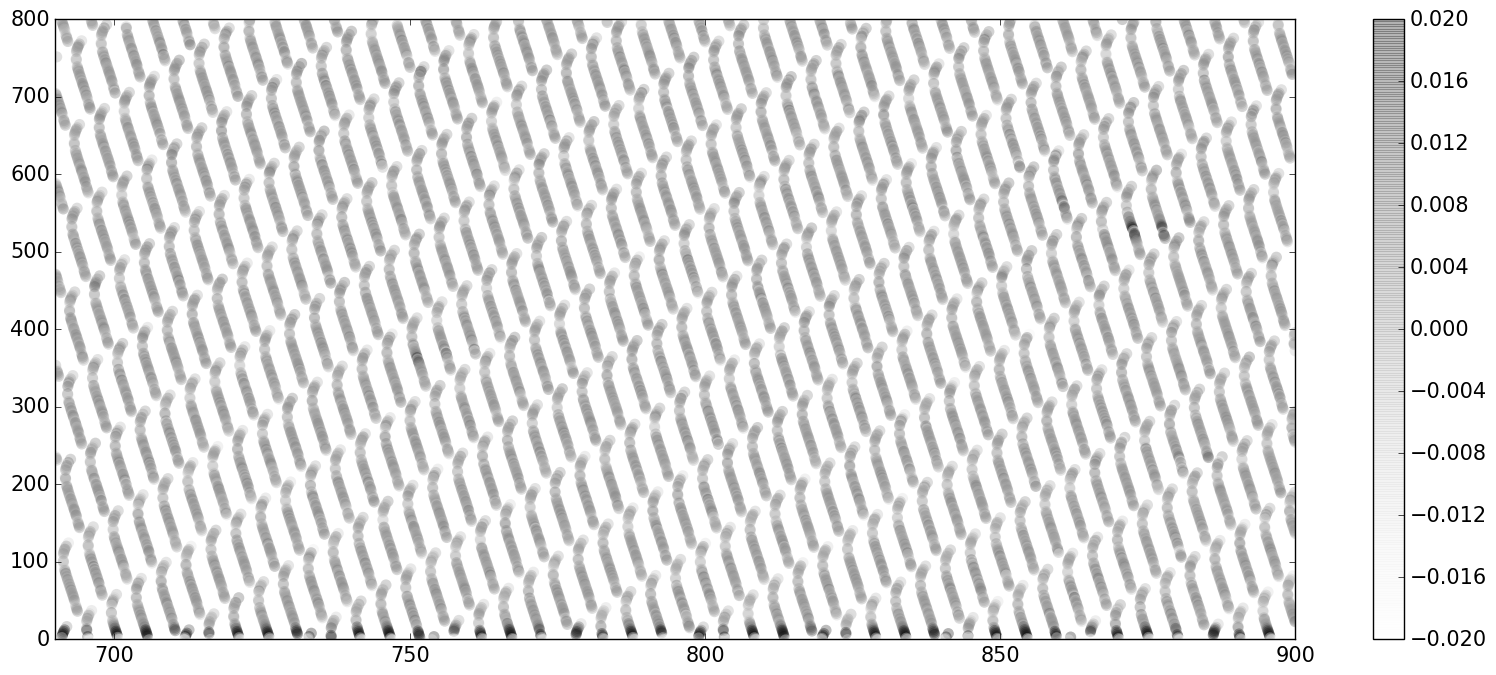

In [75]:
#plt.figure(figsize=(20,10))
#plt.imshow(filtflat[roi[2]:roi[3],roi[0]:roi[1]],vmin=-1,vmax=1,origin='lower',cmap=plt.cm.Greys,extent=roi)
#plt.colorbar()

plt.figure(figsize=(20,8))
plt.scatter(ydx,ydy,c=ydgy,vmin=-.02,vmax=.02,marker='o',alpha=.3,s=64,lw=0,label='ad data',cmap=cm.Greys)
#plt.scatter(xdx,xdy,c=xdgx,vmin=-.002,vmax=.002,marker='o',alpha=.3,s=32,lw=0,label='ad data',cmap=cm.Reds)
plt.colorbar()
plt.axis(roi)

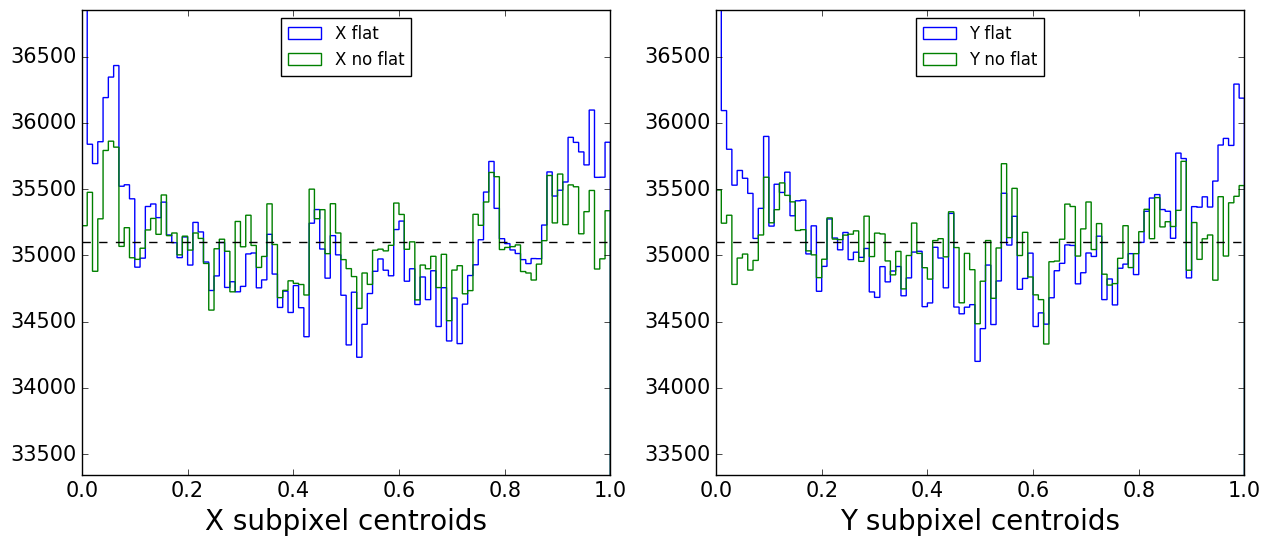

In [571]:
plt.figure(figsize=(15,6))
ncats=100
seriesnum=9

nbins=100
pct_var=.05

gridcatslist=sort(glob.glob(thedir+'/*_'+str(seriesnum)+'??_'+thedate+'*wholeflat.fits.cat'))
gridcats=[pyfits.getdata(gridcatslist[i],'LDAC_OBJECTS') for i in range(ncats)]

x_cen_subpix,y_cen_subpix=[],[]
for thecat in gridcats:
    x_cen_subpix.extend(thecat['XWIN_IMAGE']-np.floor(thecat['XWIN_IMAGE']))
    y_cen_subpix.extend(thecat['YWIN_IMAGE']-np.floor(thecat['YWIN_IMAGE']))
x_cen_subpix=np.array(x_cen_subpix)
y_cen_subpix=np.array(y_cen_subpix)


n_pin=len(x_cen_subpix)

plt.subplot(121)
plt.hist(x_cen_subpix,bins=nbins,histtype='step',label='X flat')
plt.subplot(122)
plt.hist(y_cen_subpix,bins=nbins,histtype='step',label='Y flat')

gridcatslist=sort(glob.glob(thedir+'/*_'+str(seriesnum)+'??_'+thedate+'*whole.fits.cat'))
gridcats=[pyfits.getdata(gridcatslist[i],'LDAC_OBJECTS') for i in range(ncats)]

x_cen_subpix,y_cen_subpix=[],[]
for thecat in gridcats:
    x_cen_subpix.extend(thecat['XWIN_IMAGE']-np.floor(thecat['XWIN_IMAGE']))
    y_cen_subpix.extend(thecat['YWIN_IMAGE']-np.floor(thecat['YWIN_IMAGE']))
x_cen_subpix=np.array(x_cen_subpix)
y_cen_subpix=np.array(y_cen_subpix)


n_pin=len(x_cen_subpix)

plt.subplot(121)
plt.hist(x_cen_subpix,bins=nbins,histtype='step',label='X no flat')
plt.subplot(122)
plt.hist(y_cen_subpix,bins=nbins,histtype='step',label='Y no flat')


plt.subplot(121)
plt.ylim(n_pin/nbins*(1-pct_var),n_pin/nbins*(1+pct_var))
plt.axhline(n_pin/nbins,linestyle='--',color='k')
plt.legend(loc='upper center')
plt.xlabel('X subpixel centroids',fontsize=20)
plt.subplot(122)
plt.ylim(n_pin/nbins*(1-pct_var),n_pin/nbins*(1+pct_var))
plt.axhline(n_pin/nbins,linestyle='--',color='k')
plt.legend(loc='upper center')
plt.xlabel('Y subpixel centroids',fontsize=20)

In [ ]:
# number of pixels in object aperture

In [4]:
nbins=50

xdx,xdy,xdgx,xdgy,m=np.loadtxt(savename_noflat_x)
ydx,ydy,ydgx,ydgy,m=np.loadtxt(savename_noflat_y)

xxc_sub,xyc_sub=xdx-np.floor(xdx),xdy-np.floor(xdy)
yxc_sub,yyc_sub=ydx-np.floor(ydx),ydy-np.floor(ydy)

xmedfoo,ymedfoo,yerr=median_xy(xxc_sub,xdgx,nbins)
plt.figure(figsize=(7,6))
plt.plot(xxc_sub,xdgx,'k.',alpha=.01)
plt.errorbar(xmedfoo,ymedfoo,yerr=yerr,linestyle='--',marker='o')
plt.ylim(-.0004,.0015)

xmedfoo,ymedfoo,yerr=median_xy(yyc_sub,ydgy,nbins)
plt.figure(figsize=(7,6))
plt.plot(yyc_sub,ydgy,'k.',alpha=.01)
plt.errorbar(xmedfoo,ymedfoo,yerr=yerr,linestyle='--',marker='o')
plt.ylim(-.004,.015)

NameError: name 'savename_noflat_x' is not defined

In [104]:
xdx,xdy,xdgx,xdgy,m=loadtxt(savename_flat_x)
ydx,ydy,ydgx,ydgy,m=loadtxt(savename_flat_y)